# Bank Customer Churn Prediction
This notebook trains a Logistic Regression model to predict customer churn based on demographic and account information.

In [225]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score ,roc_curve ,confusion_matrix,roc_curve
import seaborn as sns
import numpy as np
import joblib




In [226]:
train_df = pd.read_csv("../bank-customer-churn-prediction-challenge/train.csv")

# Remove unused columns

In [227]:
train_df = train_df.drop([ 'id','CustomerId', 'Surname'], axis=1)


# One hot encoding

In [228]:
df = pd.get_dummies(train_df, columns=["Geography", "Gender"], drop_first=True)


# Visualize outliers using boxplots

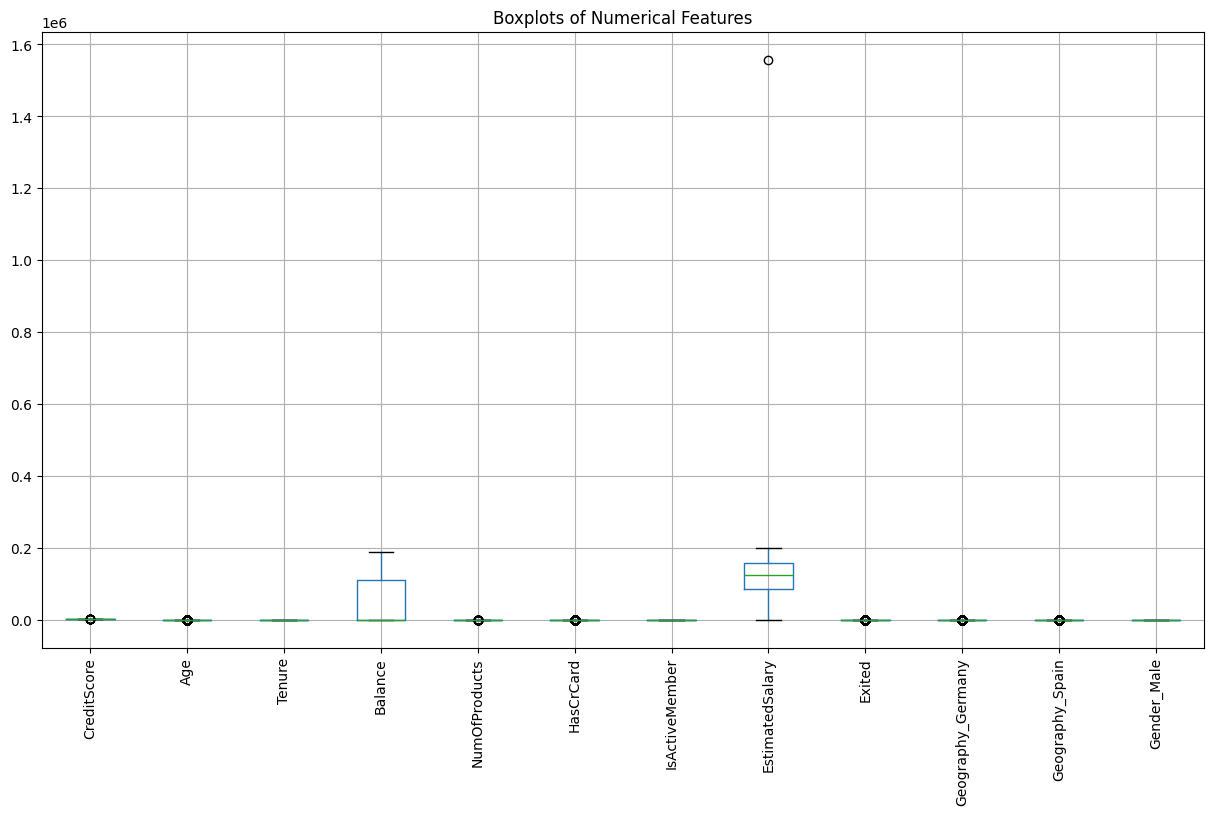

In [229]:
plt.figure(figsize=(15, 8))
df.boxplot(rot=90)
plt.title("Boxplots of Numerical Features")
plt.show()

# Split features and target


In [230]:
X = df.drop('Exited', axis=1)
y = df['Exited']

# Add target column temporarily


In [231]:
df_corr = df.copy()
df_corr["Exited"] = y

# Heatmap of correlations


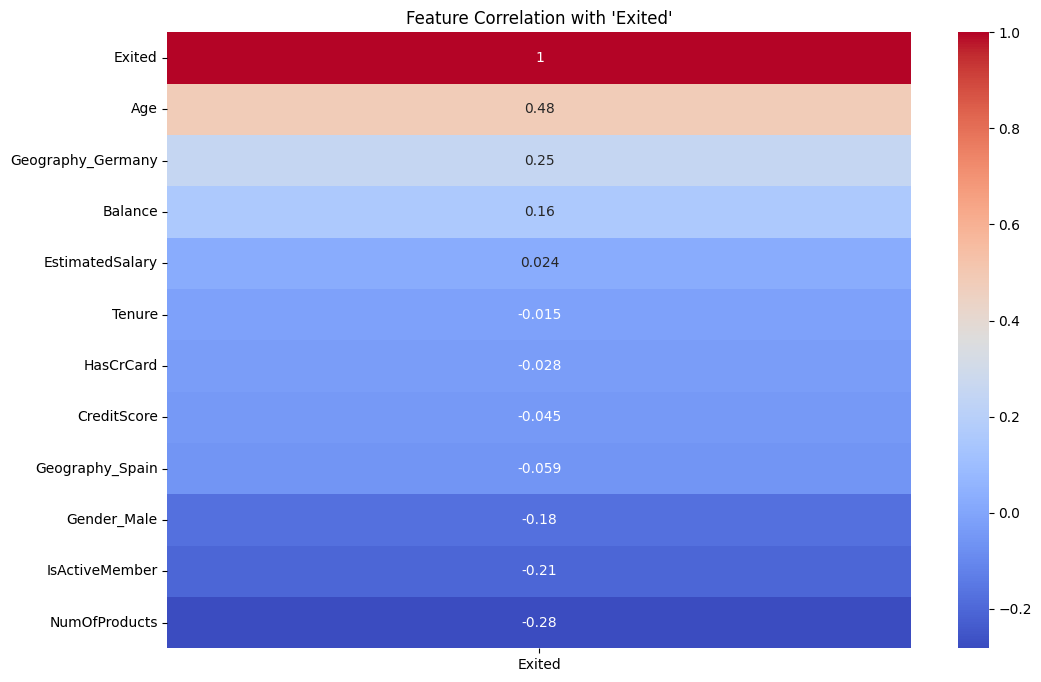

In [232]:
corr_matrix = df_corr.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['Exited']].sort_values('Exited', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with 'Exited'")
plt.show()

# Distribution of target variable


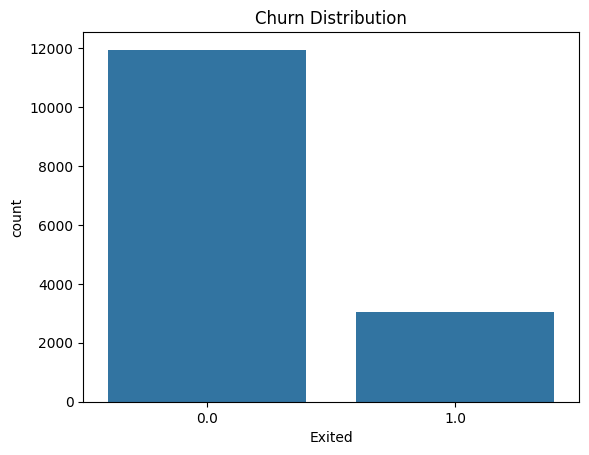

In [233]:
sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution')
plt.show()

# Age distribution by churn


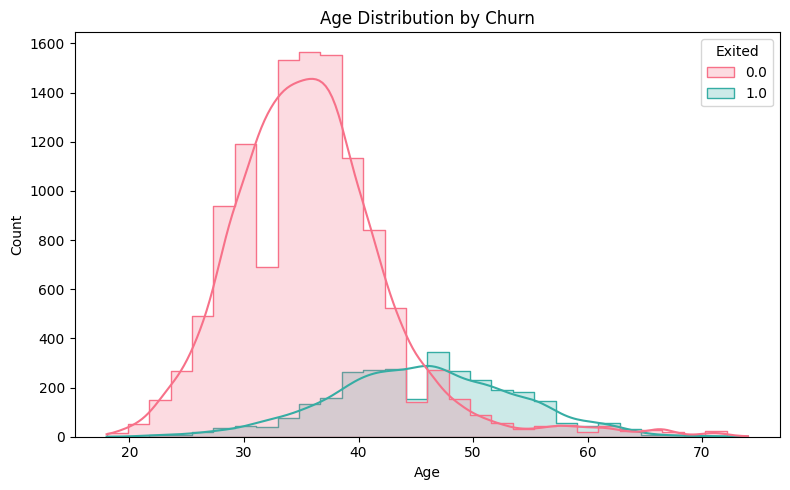

In [234]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='Exited', kde=True, bins=30, palette="husl", element="step")
plt.title("Age Distribution by Churn")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Prepare training set


In [235]:
corr_target = df.corr(numeric_only=True)['Exited'].abs()
selected_features = corr_target[corr_target > 0.05].index.tolist()
selected_features.remove('Exited') 
X_filtered = df[selected_features]

# Handle missing values


In [236]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_filtered)

# Scale features


In [237]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split

In [238]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Check For Missing Values

In [239]:
print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())

Missing values in X_train: 0
Missing values in X_test: 0


# Train Random Forest

In [240]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
joblib.dump(model, "../models/model_random_forest.pkl")
joblib.dump(imputer, "../imputer/imputer.pkl")
joblib.dump(scaler, "../scaler/scaler.pkl")
joblib.dump(X_filtered.columns, "../feature_columns/feature_columns.pkl")
print("Model trained and saved as model_random_forest.pkl")

Model trained and saved as model_random_forest.pkl


# Predict and evaluate


In [241]:
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8940
F1 Score: 0.7140
ROC AUC: 0.8116
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      2413
         1.0       0.76      0.68      0.71       587

    accuracy                           0.89      3000
   macro avg       0.84      0.81      0.82      3000
weighted avg       0.89      0.89      0.89      3000



# Confusion Matrix


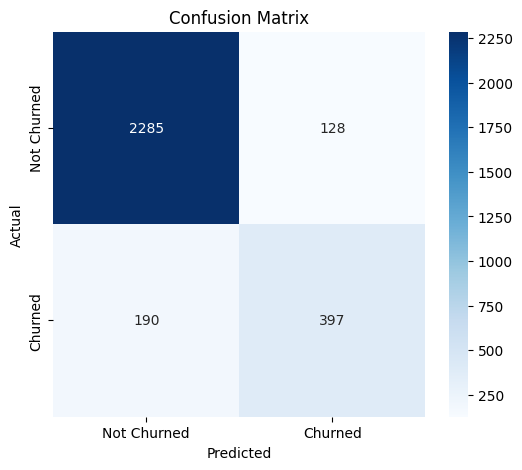

In [242]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churned", "Churned"], yticklabels=["Not Churned", "Churned"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve

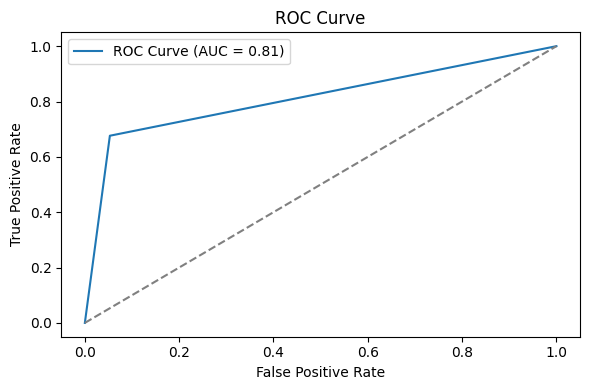

In [243]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Load Test Data

In [244]:
test_df = pd.read_csv("../bank-customer-churn-prediction-challenge/test.csv")


# Preprocess


In [245]:
def preprocess(df):
    df = df.copy()
    for col in ['id', 'CustomerId', 'Surname']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df

In [246]:
X_test_raw = preprocess(test_df)


# Align columns with training set


In [247]:
feature_columns = joblib.load("../feature_columns/feature_columns.pkl")
X_test_raw = X_test_raw.reindex(columns=feature_columns, fill_value=0)

# Apply imputer and scaler


In [248]:
imputer = joblib.load("../imputer/imputer.pkl")
scaler = joblib.load("../scaler/scaler.pkl")
X_test_imputed = imputer.transform(X_test_raw)
X_test_scaled = scaler.transform(X_test_imputed)

# Load model and predict


In [249]:
model = joblib.load("../models/model_random_forest.pkl")
probas = model.predict_proba(X_test_scaled)[:, 1]


# Create submission file


In [250]:
id_column = test_df.loc[test_data.index, 'id'] if 'id' in test_df.columns else test_df.loc[test_data.index, 'CustomerId']

submission = pd.DataFrame({
    'id': id_column,
    'Exited': probas
})

submission.to_csv("../submissions/submission_rf.csv", index=False)
print("submission_rf.csv generated")

submission_rf.csv generated


# Write Scores to CSV

In [251]:
score_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1 Score", "ROC AUC"],
    "Score": [acc, f1, roc_auc]
})
score_df.to_csv("../scores/model_scores_rf.csv", index=False)